In [176]:
# Load libraries
import pandas as pd
import numpy as np

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing libraries
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Machine learning libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [177]:
# load dataset
try:
    df = pd.read_csv('UsArrests.csv')
except FileNotFound:
    print('Could not load UsArrests.csv')
    print(error)

DATA VISUALISATION

In [178]:
# Display first 5 entries 
df.head()

,rownames,Murder,Assault,UrbanPop,Rape
0,Alabama,13.200,236,58,21.200
1,Alaska,10.000,263,48,44.500
2,Arizona,8.100,294,80,31.000
3,Arkansas,8.800,190,50,19.500
4,California,9.000,276,91,40.600


In [179]:
# Evaluate the shape of the dataset
print(f"Number of states: {df.shape[0]}\nNumber of Crime Types:{df.shape[1]}")

Number of states: 50
Number of Crime Types:5


In [180]:
# Visualise datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [181]:
# Identify missing values
missing = df.isnull().sum()
df_relevant_missing = pd.DataFrame(missing, columns=["missing"])
df_relevant_missing

,missing
rownames,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [182]:
# Visualise entries
for field in df.columns:
    print(f"Field: {field}\n{df[field].unique()}\n")

Field: rownames
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']

Field: Murder
[13.2 10.   8.1  8.8  9.   7.9  3.3  5.9 15.4 17.4  5.3  2.6 10.4  7.2
  2.2  6.   9.7  2.1 11.3  4.4 12.1  2.7 16.1  4.3 12.2  7.4 11.4 11.1
 13.   0.8  7.3  6.6  4.9  6.3  3.4 14.4  3.8 12.7  3.2  8.5  4.   5.7
  6.8]

Field: Assault
[236 263 294 190 276 204 110 238 335 211  46 120 249 113  56 115 109  83
 300 149 255  72 259 178 102 252  57 159 285 254 337  45 151 106 174 279
  86 1

All fields appear complete with no abnormal characters. Only the rownnames are non-numerical.

In [183]:
# Remove duplicates
df = df.drop_duplicates(subset=None, keep='first', inplace=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


No duplicates were found

In [184]:
# Change rownames to a more descriptive title
df = df.rename(columns={"rownames": "States"})
df.head()

,States,Murder,Assault,UrbanPop,Rape
0,Alabama,13.200,236,58,21.200
1,Alaska,10.000,263,48,44.500
2,Arizona,8.100,294,80,31.000
3,Arkansas,8.800,190,50,19.500
4,California,9.000,276,91,40.600


In [185]:
# Visualise discriptive statistics
# Set decimal precision
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Get stats
stats = df.drop('States', axis=1).describe()
selected_stats = stats.loc[["mean", "std", "min", "max"]].transpose()
selected_stats


,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


We can see that assault had a much higher stadard deviation and rate than the other fields 
and thus may skew outcomes. Scaling will be needed. 

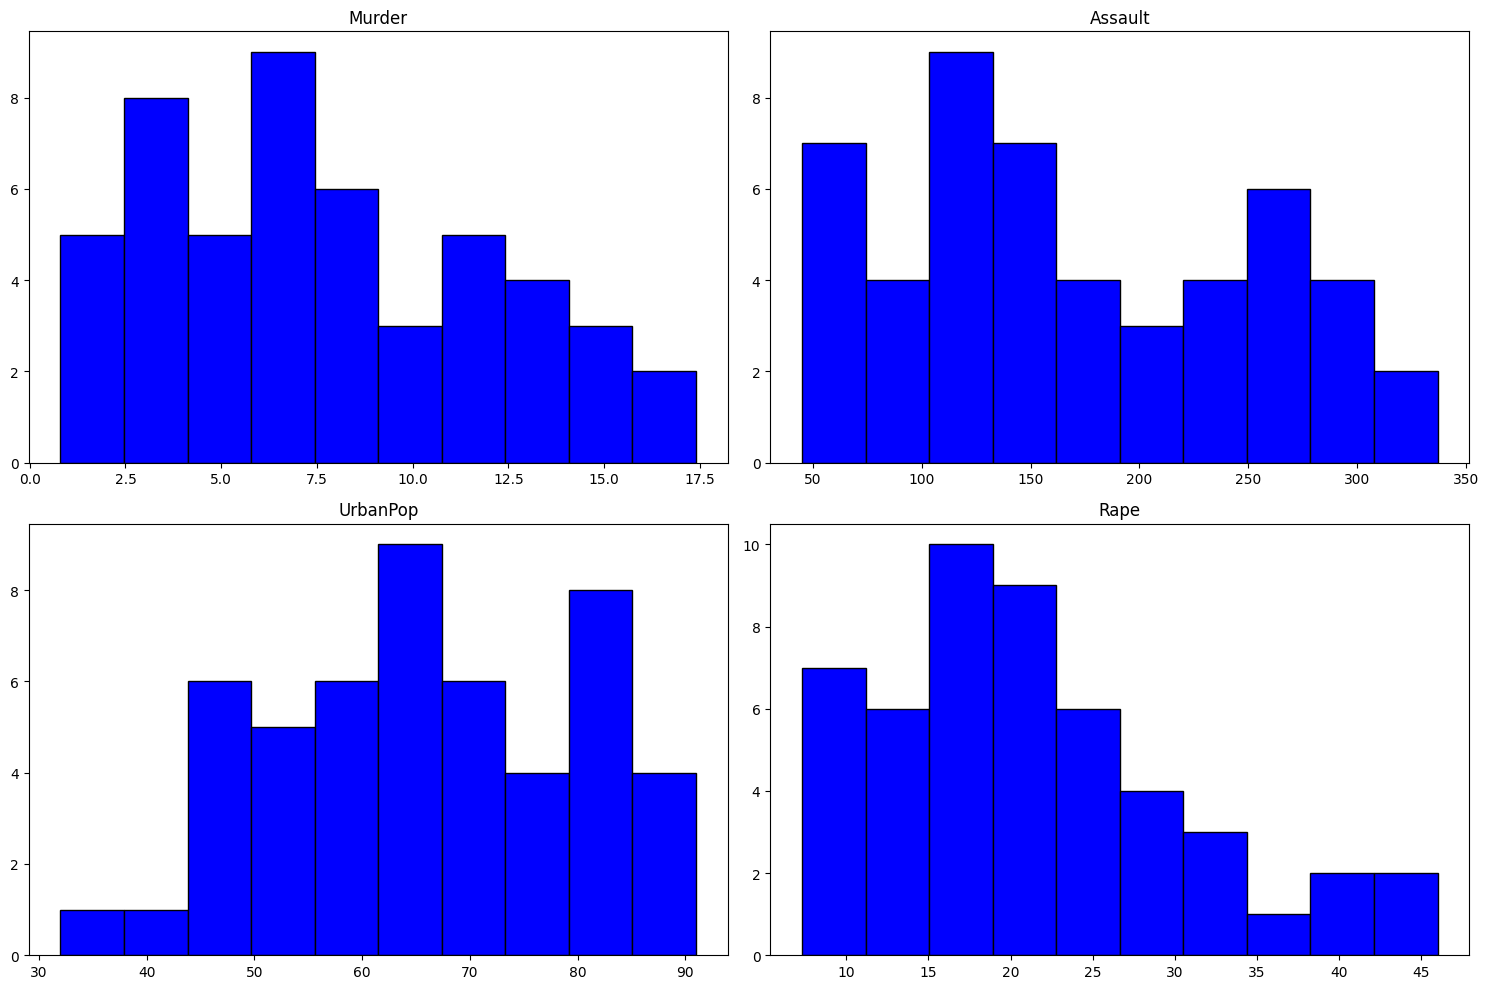

In [186]:
# Keep the states values stored seperately
states = df['States'].values
df = df.drop('States', axis=1)

# View distribution of numerical data
histograms = df.hist(color='blue', edgecolor='black', grid=False,
                    figsize=(15, 10))
plt.tight_layout()
plt.show()

Non-normal distributions noted. Normalisation is more appropriate than standardisation. 

In [187]:
# Create a heatmap function
def plot_heat_map(df):
    mask_ut=np.triu(np.ones(df.shape)).astype(np.bool)
    sns.heatmap(df, mask=mask_ut, cmap="coolwarm")

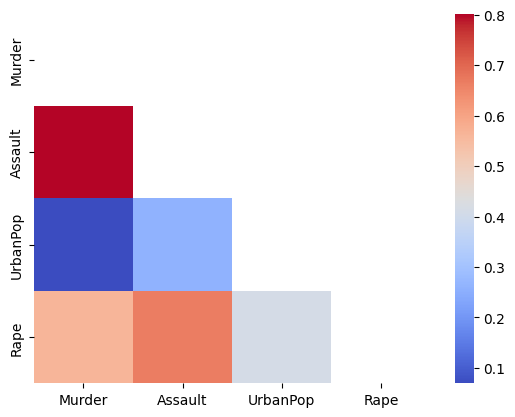

In [188]:
# Investigate correlations
corr_df = df.corr()
plot_heat_map(corr_df)

Considerinh the unstandardised data Rape appears to have the highest correlation with UrbanPop and no features have negative correlations. 

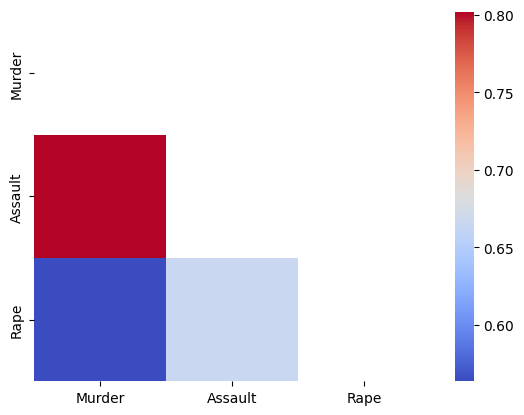

In [189]:
feature_corr_df = df.drop('UrbanPop', axis=1).corr()
plot_heat_map(feature_corr_df)
labels = feature_corr_df.columns

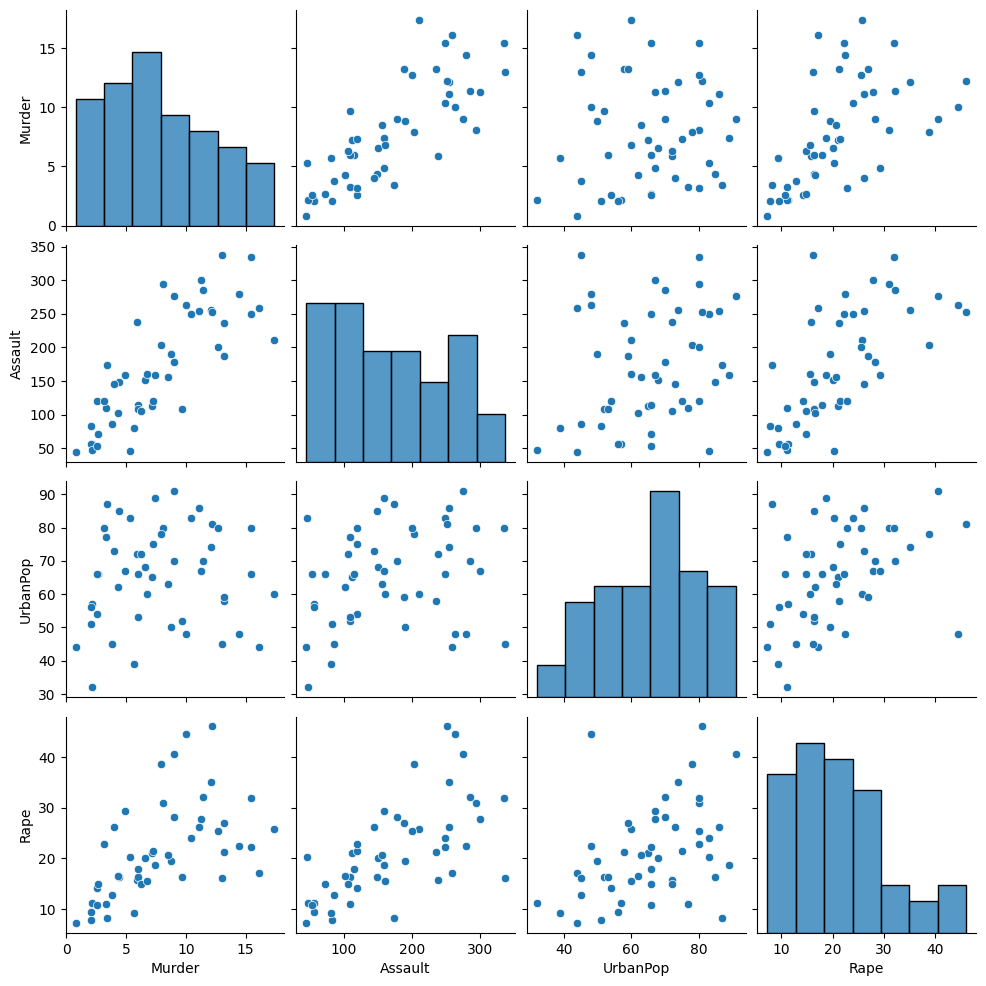

In [190]:
# Create a pairplot
sns.pairplot(df)
plt.show()

Murder seems to be moderately correlated with Rape and strongly correlated with assault which makes sense. There appears to be a linear correlation between the different fields. 

In [191]:
# Get X values
X = df.drop('UrbanPop', axis=1).values
urban_pop = df['UrbanPop'].values
scaler = MinMaxScaler()
X=scaler.fit_transform(X)

In [192]:
# Apply PCA
pca = PCA()

# Transform data
X_trans = pca.fit_transform(X)
df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2
0,0.34,-0.20,-0.05
1,0.57,0.39,0.00
2,0.41,0.13,0.24
3,0.06,-0.08,0.02
4,0.52,0.33,0.10


In [193]:
# Calculate standard deviation
std = df_pca.describe().transpose()['std']
print(f"Standard deviation: {std.values}")

Standard deviation: [0.40836023 0.16838739 0.11731191]


There are 3 principal components identified with the first having the highest standard deviation and thus variance. 

In [194]:
# Calculating the proportion of variance explained
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [0.79836504 0.13574809 0.06588686]


The PC1 explains a massive 79% of the variance while the third makes a very small contribution. 

In [195]:
# Calculating the cumulative variance
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_ratio_)}")

Cumulative Proportion: [0.79836504 0.93411314 1.        ]


All of the variance in data is explained by the 2 principal components.

In [196]:
# Create a biplot function
def biplot(score, coeff, labels=None, points=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()

    ax.scatter(xs * scalex, ys * scaley, s=5)
    for i in range(0, len(xs)):
        txt = urban_pop[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley), fontsize=8)

        
    for i in range(n):
        ax.arrow(0, 0, coeff[i, 0], coeff[i, 1], color = 'r', 
                 head_width=0.02, alpha = 0.5)
        if labels is None:
            ax.text(coeff[i, 0]*1.15, coeff[i, 1] * 1.15, "Var"+str(i+1), 
                   color = 'green', ha= 'center', va = 'center')
        else:
            ax.text(coeff[i, 0]* 1.15, coeff[i, 1] * 1.15, labels[i], color = 'g',
                   ha = 'center', va = 'center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    

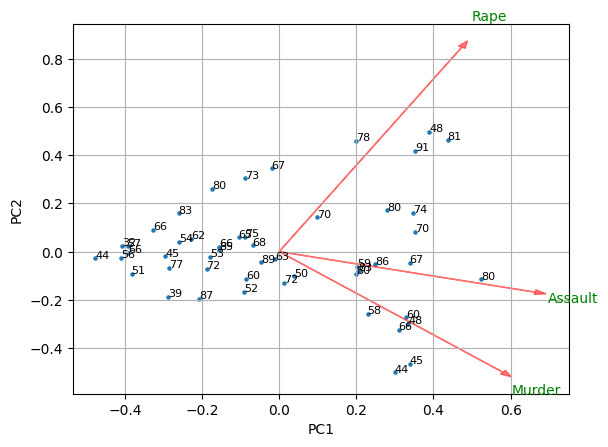

In [197]:
biplot(X_trans[:, 0:2], np.transpose(pca.components_[0:2, :]), list(labels), list(states))

Based on the Biplot we can see that Rape has the highest influence on PC2 while Assault and Murder appear to affect PC1.

In [198]:
# Display feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Components x features
pc1 = abs(pca.components_[0])
pc2 = abs(pca.components_[1])

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df


,Features,PC1 Importance,PC2 Importance
0,Murder,0.580,0.501
1,Assault,0.663,0.168
2,Rape,0.473,0.849


Balanced contribution seen

Text(0.5, 1.0, 'Cumulative Explained Variance')

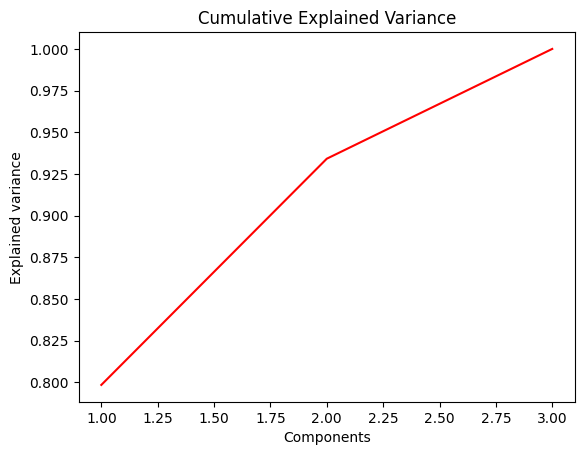

In [199]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
        np.cumsum(pca.explained_variance_ratio_), 
        c='red')
plt.title("Cumulative Explained Variance")

It appears that all components contribute to the variance, but the first 3 explain about 95% of the variance.

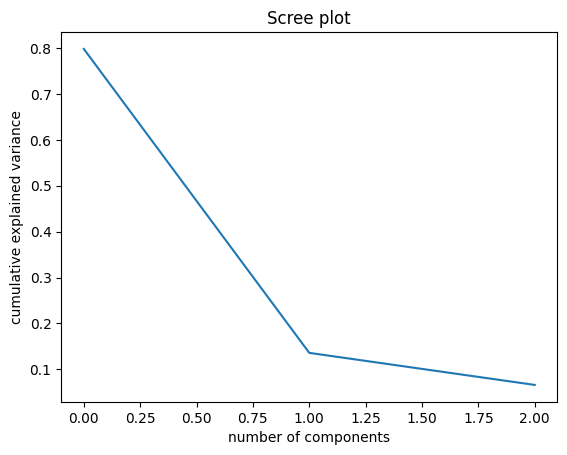

In [161]:
# Scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Scree plot')
plt.show()

The first 2 components explain most of the variability

In [200]:
# Extract the first 2 components for furher analysis. 
pca_df = pd.DataFrame(X_trans[:, 0:3], index = df.index)
pca_df.head()

,0,1,2
0,0.337,-0.202,-0.046
1,0.571,0.391,0.004
2,0.410,0.134,0.237
3,0.058,-0.080,0.019
4,0.518,0.328,0.099


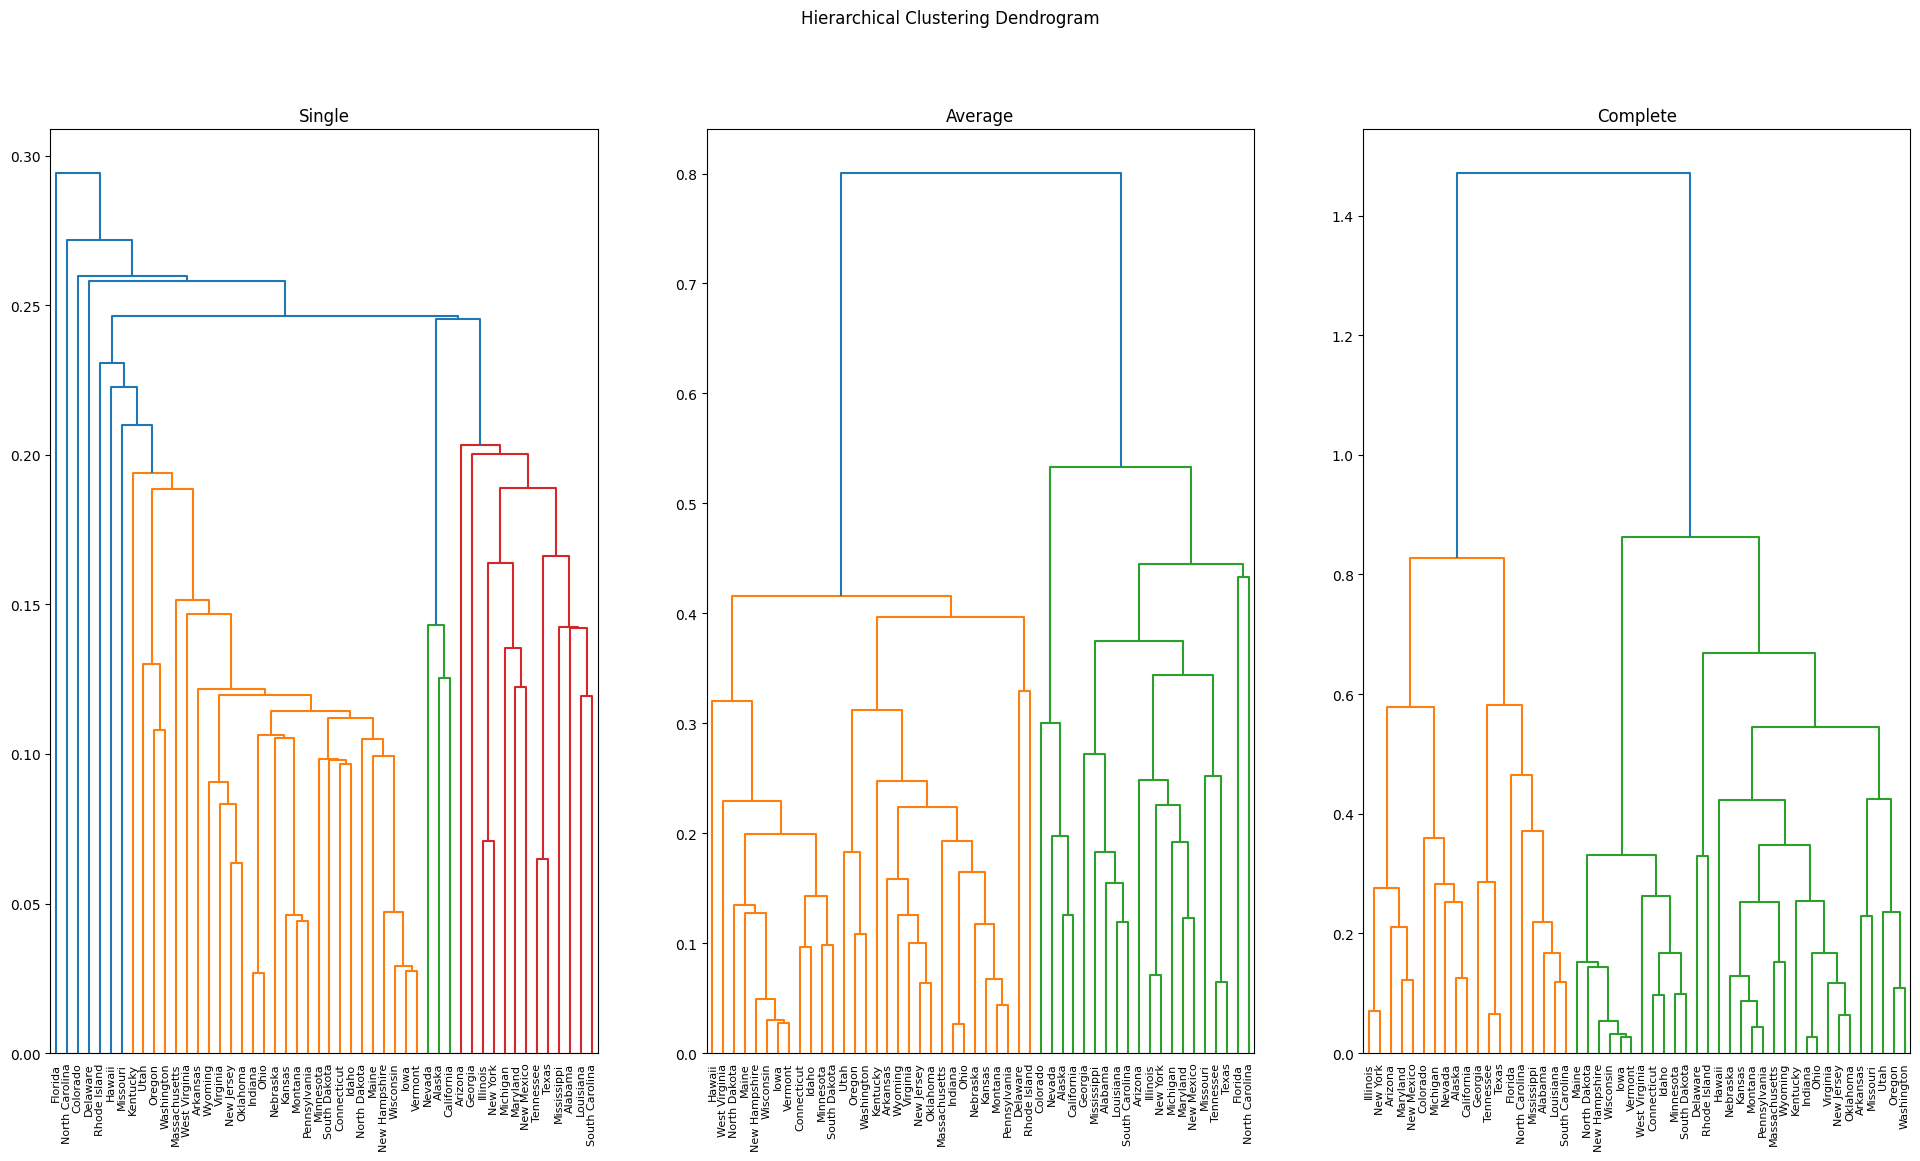

In [201]:
# Hierarchical clustering

# Cluster data and plot a dendrogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=states, ax=ax1)
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=states, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method="complete"), labels=states, ax=ax3)
plt.show()


The most balanced dendrogram leads to 2 clusters and the most disparity is seen with Complete Linkage.

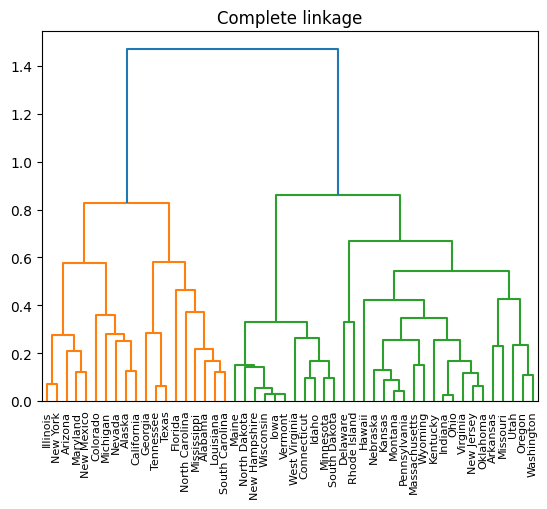

In [202]:
# Plot complete linkage dendrogram
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels = states)
plt.show()

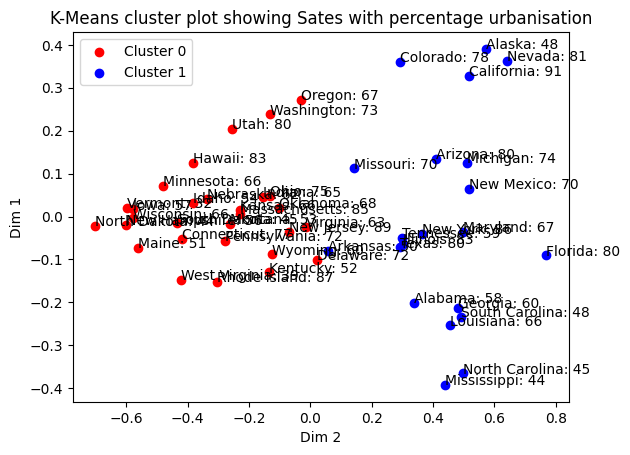

In [175]:
# K-means clustering

x = X_trans[:, 0]
y = X_trans[:, 1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0, k):
    ax.scatter(x[cluster_labels == i], y[cluster_labels == i], c=colours[i], 
              label=f"Cluster {i}")

for i in range(0, len(x)):
    txt = f"{states[i]}: {urban_pop[i]}"
    ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot showing Sates with percentage urbanisation")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

K-means clustering identified 2 clusters. Blue (cluster 1) representing higher crime rates as apposed to red. Many Southern states are noted in blue cluster although there are geographical outliers also like Alaska.  At first glance the percentage urbanisation seems higher in the blue cluster.

In [166]:
sil_score = silhouette_score(X, cluster_labels, metric='euclidean')
print('K-means Clustering Silhouette Score', sil_score)

K-means Clustering Silhouette Score 0.5215452028450616


In [168]:
print(cluster_labels)

[1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 0]


In [169]:
df['cluster'] = cluster_labels

In [170]:
def compare_box_same(df, column_variable, column_grouping, 
                     title_variable, title_grouping, title):
    '''
    Receives dataframe, 2 column references and 2 titles 
    Plots 2 side by side box-plots with the same axes (intervals)
    '''
    df_box = df[[column_variable, column_grouping]]
    
    sns.boxplot(data=df_box, x=column_grouping, y=column_variable)
    plt.xlabel(column_grouping)
    plt.ylabel(column_variable)
    plt.title(title)
    plt.show()

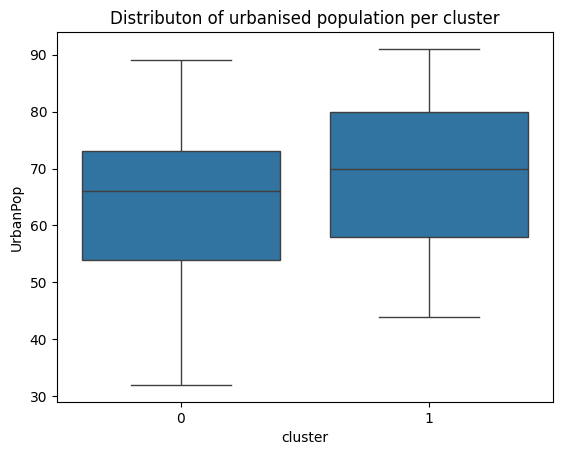

In [171]:
compare_box_same(df, 'UrbanPop', 'cluster', 'Urban Population Percentage', 
                'Grouped by cluster of high and low crime', 
                'Distributon of urbanised population per cluster')

Cluster 2 shows higher rates of crime and a slightly higher median and overall urbanpopulation while there is overlap. 